In [1]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler, StableDiffusionImg2ImgPipeline, image_processor
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import numpy as np
from PIL import Image
import torch.nn.functional as F
from diffusers.models.attention import Attention
from typing import Optional
import requests
from io import BytesIO
# from tqdm.auto import tqdm
from tqdm import tqdm

/Users/andrewbelyaev/UIUC/SemanticAttack/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
class AttnProcessor:
    """
    Default processor for performing attention-related computations.
    """
    def __init__(self):
        # Initialize an empty list to store attention maps for each call
        self.attention_maps = []
        # self.hidden_states = []
        # self.encoder_hidden_states = []
        # self.attention_mask = []

    def __call__(
        self,
        attn: Attention,
        hidden_states: torch.Tensor,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        temb: Optional[torch.Tensor] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)

        res = int(np.sqrt(attention_probs.shape[1]))
        num_tokens = attention_probs.shape[-1]
        self.attention_maps.append(attention_probs.view(-1, res, res, num_tokens))
        # self.hidden_states.append(hidden_states)
        # self.encoder_hidden_states.append(encoder_hidden_states)
        # self.attention_mask.append(attention_mask)

        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

In [76]:
class SemanticAttack():
    def __init__(self,
                 image,
                 editing_prompt,
                 token, device,
                 attention_processor_class=AttnProcessor,
                 num_inference_steps_mask=50,
                 mask_threshold=0.5,
                 perturbation_budget=0.06,
                 attacking_step_size=0.01,
                 number_of_attacking_steps=100,
                 num_diffusion_steps=10) -> None:

        self.token = token
        self.editing_prompt = editing_prompt
        self.attention_processor_class = attention_processor_class
        # self.attention_maps = {}

        # constants (move it to the sem att function
        self.mask_threshold = mask_threshold
        self.perturbation_budget = perturbation_budget
        self.attacking_step_size = attacking_step_size
        self.number_of_attacking_steps = number_of_attacking_steps
        self.num_diffusion_steps = num_diffusion_steps

        self.strength = 0.5
        self.guidance_scale = 6
        self.num_inference_steps_mask = num_inference_steps_mask

        # Initializing block for the Stable Diffusion Model
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
        self.tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder",
                                                          use_safetensors=True)
        self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet",
                                                         use_safetensors=True)
        self.scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

        # Let's also save pipeline to use it's functions
        self.pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                                                       safety_checker=None,
                                                                       requires_safety_checker=False)

        # choosing device
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
        print("Using:", self.device)

        self.generator = torch.Generator(device=self.device)
        torch.manual_seed(0)

        self.vae.to(self.device)
        self.text_encoder.to(self.device)
        self.unet.to(self.device)

        self.image = image
        self.preprocessed_image = self.pipeline.image_processor.preprocess(image).to(
            self.device)  # maybe VAE image processor?

        self.transformer_block_name_to_attention_processor_map = {}
        self.register_custom_attention_processors()

        self.mask = None
        self.latent_shape = None
        self.text_embeddings = None
        self.init_latent = None

        self.loss = []

    def upsample_attention(self, attention_map, target_res):  # works
        '''
        Upsamples attention map to a specific shape
        attention_map: torch.Tensor of size: [batch_size * n_heads, res, res, n_tokens]
        shape: tuple,
        return: torch.Tensor of size: [batch_size * n_heads, target_res, target_res, n_tokens]
        '''
        batch_size_n_heads, _, res, n_tokens = attention_map.shape
        # [batch_size * n_heads, target_res, target_res, n_tokens] -> [batch_size * n_heads * n_tokens, 1, target_res, target_res]
        attention_map = attention_map.permute(0, 3, 1, 2).reshape(-1, 1, res, res)
        attention_map = F.interpolate(attention_map, size=(target_res, target_res), mode='bicubic', align_corners=False)
        # [batch_size * n_heads * n_tokens, 1, target_res, target_res] -> [batch_size * n_heads, target_res, target_res, n_tokens]
        attention_map = attention_map.reshape(batch_size_n_heads, n_tokens, target_res, target_res).permute(0, 2, 3, 1)
        return attention_map

    def average_attention_maps(self):  # works
        '''
        Upsamples the attention maps and averages them across all layers.
        num_steps: int, the number of timesteps to average over.
        '''
        resolution_to_upsample_to = 64
        to_average = []
        for key, value in self.transformer_block_name_to_attention_processor_map.items():
            # attention_map = value.attention_maps[-num_steps:].copy()
            # attention_map = sum(attention_map) / len(attention_map)
            avg_attention_map = value.sum_attention_maps / value.counter
            res = avg_attention_map.shape[1]
            if res == resolution_to_upsample_to:
                to_average.append(avg_attention_map)
            else:
                to_average.append(self.upsample_attention(avg_attention_map, resolution_to_upsample_to))
        to_average = torch.cat(to_average, dim=0)
        averaged = to_average.sum(dim=0) / to_average.shape[0]
        # del to_average
        # del attention_map
        return averaged

    def denoise(self):
        '''
        Generates mask using sampling from the noisy state obtained with forward pass.
        '''
        # check_memory()

        # text embeddings
        text_embeddings = self.get_text_embeddings(prompt=self.token)
        # print(get_tensor_size(text_embeddings))

        with torch.no_grad():
            # timesteps
            self.scheduler.set_timesteps(self.num_inference_steps_mask, device=self.device)

            init_timestep = min(int(self.num_inference_steps_mask * self.strength), self.num_inference_steps_mask)
            t_start = max(self.num_inference_steps_mask - init_timestep, 0)

            timesteps = self.scheduler.timesteps[t_start:]
            num_inference_steps = self.num_inference_steps_mask - t_start

            # latents
            # init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            init_latent = self.get_init_latent()

            # print(get_tensor_size(init_latent))
            self.latent_shape = init_latent.shape
            init_latent = self.vae.config.scaling_factor * init_latent
            noise = torch.randn(init_latent.shape, generator=self.generator, device=self.device)
            latent_timestep = timesteps[:1]
            latent = self.scheduler.add_noise(init_latent, noise, latent_timestep)

            for t in tqdm(timesteps, total=len(timesteps)):
                latent_model_input = torch.cat([latent] * 2)  # cfg
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                # print(get_tensor_size(latent_model_input))

                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings,
                    # timestep_cond=None,
                    # cross_attention_kwargs=self.cross_attention_kwargs,
                    # added_cond_kwargs=added_cond_kwargs,
                    # return_dict=False,
                )[0]

                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                latent = self.scheduler.step(noise_pred, t, latent, return_dict=False)[0]
        return

    def generate_mask_using_forward_noise(self):
        self.clean_attention_processors()
        self.denoise()
        attention_map = self.average_attention_maps()
        token_attention_map = attention_map[:, :, 1]
        masked_token_attention_map = token_attention_map * (token_attention_map > token_attention_map.max() * self.mask_threshold)
        mask = masked_token_attention_map.unsqueeze(0).unsqueeze(0).repeat(1, self.latent_shape[1], 1, 1)
        self.mask = mask
        self.clean_attention_processors()

    def clean_attention_processors(self):
        for key, value in self.transformer_block_name_to_attention_processor_map.items():
            value.sum_attention_maps = None
            value.counter = 0
        # gc.collect()

    def get_text_embeddings(self, prompt):
        '''
        Gets text embedding with classifier-free guidance
        :return: text embeddings
        '''

        if self.text_embeddings is None:

            text_input = self.tokenizer(
                prompt,
                padding="max_length",
                # max_length=self.tokenizer.model_max_length,
                max_length=10,
                truncation=True,
                return_tensors="pt",
            )
            with torch.no_grad():
                # embeddings
                text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

                # classifier free guidance
                max_length = text_input.input_ids.shape[-1]
                uncond_input = self.tokenizer("", padding="max_length", max_length=max_length, return_tensors="pt")
                uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

                text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

                self.text_embeddings = text_embeddings

        else:
            text_embeddings = self.text_embeddings

        return text_embeddings

    def get_init_latent(self):
        if self.init_latent is None:
            init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            self.init_latent = init_latent
        else:
            init_latent = self.init_latent
        return init_latent

    def timestep_universal_gradient_updating(self):
        '''
        Performs universal gradient updating.
        '''

        text_embeddings = self.get_text_embeddings(prompt=self.token)
        # text_embeddings = self.text_embeddings

        self.scheduler.set_timesteps(self.num_diffusion_steps, device=self.device)

        diffusion_timesteps = self.scheduler.timesteps

        with torch.no_grad():
            # init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            init_latent = self.get_init_latent().to(self.device)
            init_latent = (self.vae.config.scaling_factor * init_latent).to(self.device)
            delta = torch.zeros(init_latent.shape).to(self.device)


        for attacking_step in tqdm(range(self.number_of_attacking_steps), total=self.number_of_attacking_steps,
                                   desc="Attacking steps"):
            accumulated_grad = torch.zeros(init_latent.shape).to(self.device).requires_grad_(False)  # Accumulate gradient across timesteps
            for t in tqdm(diffusion_timesteps, total=len(diffusion_timesteps),
                          desc=f"Attacking step {attacking_step + 1}"):
                with torch.autograd.profiler.profile() as prof:
                    init_latent_adv = init_latent.clone().detach().requires_grad_(True)
                    noise = torch.randn(init_latent_adv.shape, generator=self.generator, device=self.device)
                    noised_adv_latent = self.scheduler.add_noise(init_latent_adv, noise, t)

                    latent_model_input = torch.cat([noised_adv_latent] * 2)  # cfg
                    latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                    masked_latent_model_input = self.mask * latent_model_input
                    noise_pred = self.unet(
                        masked_latent_model_input,
                        t,
                        encoder_hidden_states=text_embeddings,
                        # timestep_cond=None,
                        # cross_attention_kwargs=self.cross_attention_kwargs,
                        # added_cond_kwargs=added_cond_kwargs,
                        # return_dict=False,
                    )[0]
                    # del noise_pred

                    # calculating loss
                    attention_map = self.average_attention_maps()[:, :, 1]
                    if init_latent_adv.grad is not None:
                        init_latent_adv.grad.zero_()
                    loss = torch.norm(attention_map, p=1)
                    self.loss.append(loss.item())
                    # loss = torch.norm(latent_model_input)
                    loss.backward()

                    ##
                    # self.print_graph(attention_map)
                    ##
                    with torch.no_grad():
                        accumulated_grad += init_latent_adv.grad
                self.clean_attention_processors()

                # print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))
                # for event in prof.function_events:
                #     print(event)
            grad = accumulated_grad / len(diffusion_timesteps)
            delta = delta + self.attacking_step_size * torch.sign(grad)
            delta.clamp_(-self.perturbation_budget, self.perturbation_budget)
            with torch.no_grad():
                init_latent = (init_latent - delta).detach()  # Reset for next step

        return init_latent

    def register_custom_attention_processors(self):
        '''
        Registers a custom attention processor for each BasicTransformerBlock in the U-Net to extract attention maps after softmax.
        processor: class
        '''
        for name, module in self.unet.named_modules():
            if module.__class__.__name__ == 'BasicTransformerBlock':
                module.attn2.processor = self.attention_processor_class()
                self.transformer_block_name_to_attention_processor_map[name] = module.attn2.processor

    def show_attention_maps(self, directions, token, resolution):
        '''
        Shows averaged cross attention across timesteps, batch * n_heads, and layers
        with the same resolution attention maps for a given resolution and direction.
        direction: list, for example ["down", "up", "mid"]
        token: int, for example 1
        resolution: int for example 16
        '''
        filtered_attention_sums = []
        for key, value in self.transformer_block_name_to_attention_processor.items():
            dir = key.split("_")[0]
            res = value.sum_attention_maps.shape[1]
            if dir in directions and res == resolution:
                filtered_attention_sums.append(value.sum_attention_maps)
        filtered_attention_sums = torch.cat(filtered_attention_sums, dim=0)
        filtered_attention_sums = filtered_attention_sums.sum(dim=0) / filtered_attention_sums.shape[0]
        filtered_attention_sums = filtered_attention_sums[:, :, token]
        filtered_attention_sums = 255 * filtered_attention_sums / filtered_attention_sums.max()
        filtered_attention_sums = filtered_attention_sums.unsqueeze(-1).expand(*filtered_attention_sums.shape, 3)
        filtered_attention_sums = filtered_attention_sums.numpy().astype(np.uint8)
        return Image.fromarray(filtered_attention_sums).resize((256, 256))


In [2]:
def load_image(url, size=None):
    response = requests.get(url,timeout=1)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

In [3]:
# input_image = load_image('https://images.pexels.com/photos/415829/pexels-photo-415829.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2', size=(640//2, 564//2))
input_image = load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
# from google.colab import drive
# drive.mount('/content/drive')

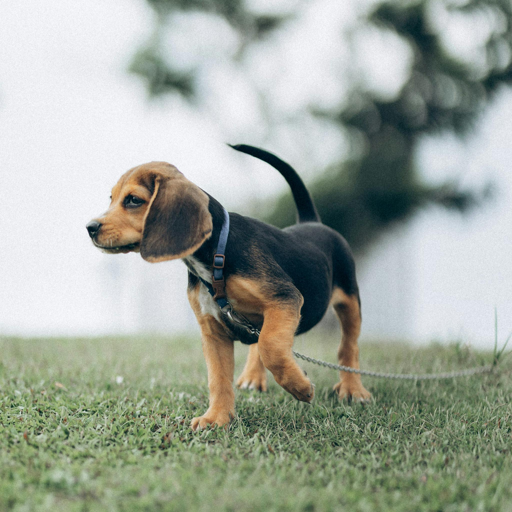

In [4]:
input_image

In [40]:
input_image.

TypeError: 'Image' object is not subscriptable

In [10]:
torch.from_numpy(np.array(input_image))

tensor([[[235, 236, 240],
         [239, 240, 244],
         [243, 244, 248],
         ...,
         [115, 132, 120],
         [128, 141, 131],
         [137, 149, 139]],

        [[240, 241, 245],
         [239, 240, 244],
         [243, 244, 248],
         ...,
         [112, 129, 117],
         [127, 140, 130],
         [135, 147, 137]],

        [[244, 245, 249],
         [241, 242, 246],
         [237, 238, 242],
         ...,
         [105, 122, 111],
         [121, 134, 124],
         [131, 143, 133]],

        ...,

        [[120, 132,  96],
         [123, 135,  99],
         [121, 133,  97],
         ...,
         [147, 157, 132],
         [149, 159, 134],
         [145, 155, 130]],

        [[120, 129,  94],
         [128, 137, 102],
         [126, 134, 100],
         ...,
         [149, 159, 134],
         [149, 159, 134],
         [143, 153, 128]],

        [[127, 134, 100],
         [129, 136, 102],
         [130, 137, 103],
         ...,
         [144, 154, 129],
        

In [77]:
model = SemanticAttack(image=input_image,
              editing_prompt="cat on the grass",
              token='dog',
              device="cpu",
              attention_processor_class=AttnProcessor,
              #  pipeline_class=StableDiffusionImg2ImgPipeline,
              #  scheduler_class=DDIMScheduler,
              num_inference_steps_mask=50)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Using: cpu


In [41]:
model.preprocessed_image

tensor([[[[ 0.8431,  0.8745,  0.9059,  ..., -0.0980,  0.0039,  0.0745],
          [ 0.8824,  0.8745,  0.9059,  ..., -0.1216, -0.0039,  0.0588],
          [ 0.9137,  0.8902,  0.8588,  ..., -0.1765, -0.0510,  0.0275],
          ...,
          [-0.0588, -0.0353, -0.0510,  ...,  0.1529,  0.1686,  0.1373],
          [-0.0588,  0.0039, -0.0118,  ...,  0.1686,  0.1686,  0.1216],
          [-0.0039,  0.0118,  0.0196,  ...,  0.1294,  0.1686,  0.1451]],

         [[ 0.8510,  0.8824,  0.9137,  ...,  0.0353,  0.1059,  0.1686],
          [ 0.8902,  0.8824,  0.9137,  ...,  0.0118,  0.0980,  0.1529],
          [ 0.9216,  0.8980,  0.8667,  ..., -0.0431,  0.0510,  0.1216],
          ...,
          [ 0.0353,  0.0588,  0.0431,  ...,  0.2314,  0.2471,  0.2157],
          [ 0.0118,  0.0745,  0.0510,  ...,  0.2471,  0.2471,  0.2000],
          [ 0.0510,  0.0667,  0.0745,  ...,  0.2078,  0.2471,  0.2235]],

         [[ 0.8824,  0.9137,  0.9451,  ..., -0.0588,  0.0275,  0.0902],
          [ 0.9216,  0.9137,  

In [53]:
for param in model.vae.parameters():
    # param.requires_grad = True
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [78]:
image_adv = model.preprocessed_image.clone().detach().requires_grad_(True)
# model.vae.train()
latent = model.vae.encode(image_adv).latent_dist.sample(model.generator)

In [79]:
loss = latent.mean()  # Example loss
loss.backward()  # This should not raise any errors
print(loss)

tensor(1.1737, grad_fn=<MeanBackward0>)


In [80]:
image_adv.grad

tensor([[[[-4.0758e-04, -1.2727e-04,  5.7062e-05,  ..., -1.3879e-05,
           -1.0123e-05, -4.6047e-07],
          [-1.7829e-04,  3.8102e-04,  3.9814e-04,  ...,  6.5337e-06,
           -4.0270e-06, -4.7245e-06],
          [-1.0417e-04,  7.1740e-04,  6.2096e-04,  ..., -6.7999e-06,
            1.7495e-05,  9.2273e-06],
          ...,
          [-1.7986e-06,  4.6161e-05,  2.7348e-05,  ...,  1.2248e-05,
           -2.0127e-05,  1.7862e-05],
          [-1.0560e-05,  6.3606e-05,  3.3376e-05,  ...,  1.0944e-04,
            6.8569e-06,  1.3178e-06],
          [-1.4212e-05,  1.8544e-05,  3.1712e-05,  ...,  6.4114e-06,
           -2.0647e-05,  3.8740e-06]],

         [[-1.2451e-04,  6.1693e-05,  1.3422e-04,  ..., -2.3411e-05,
           -1.1760e-05,  6.2840e-06],
          [-1.7841e-04,  1.2615e-04,  1.4411e-04,  ...,  1.4213e-06,
           -1.4932e-06,  5.5853e-06],
          [-1.4662e-04,  2.1962e-04,  3.2836e-04,  ..., -1.6088e-05,
            3.5160e-05,  3.5602e-05],
          ...,
     

In [68]:
latent.grad

/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_82762/3022972074.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  latent.grad


In [29]:
init_latent_adv = latent.clone().detach()

AttributeError: 'AutoencoderKLOutput' object has no attribute 'clone'

In [8]:
model.generate_mask_using_forward_noise()

100%|██████████| 25/25 [01:31<00:00,  3.66s/it]


In [10]:
immunized_latent = model.timestep_universal_gradient_updating()

Attacking steps:   0%|          | 0/10 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [39]:
decoded_latent = model.vae.decode(immunized_latent / model.vae.config.scaling_factor, return_dict=False, generator=model.generator)[0]

In [40]:
immunized_image = model.pipeline.image_processor.postprocess(decoded_latent.detach(), output_type='pil', do_denormalize=[True])

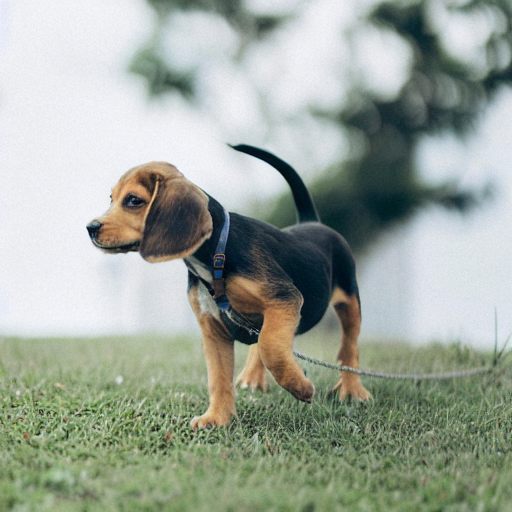

In [41]:
immunized_image[0]

In [42]:
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", safety_checker = None, requires_safety_checker = False)
# pipeline.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [43]:
pipeline_output = pipeline(prompt='cat on the grass', image=immunized_image[0],  strength=0.7, guidance_scale=6, num_inference_steps=50)

  0%|          | 0/30 [00:00<?, ?it/s]

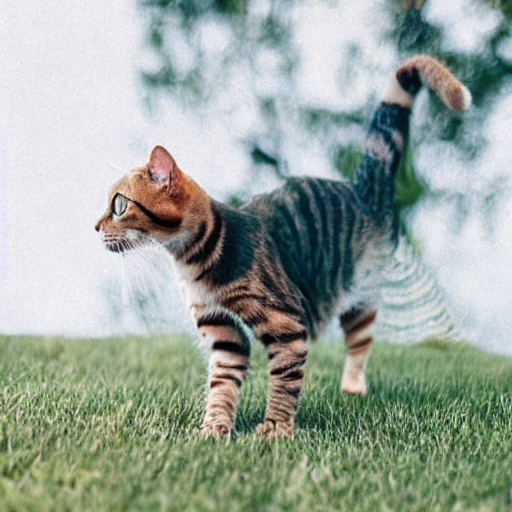

In [44]:
pipeline_output.images[0]

In [34]:
not_immunized_pipeline_output = pipeline(prompt='cat on the grass', image=input_image,  strength=0.7, guidance_scale=6, num_inference_steps=50)

  0%|          | 0/35 [00:00<?, ?it/s]

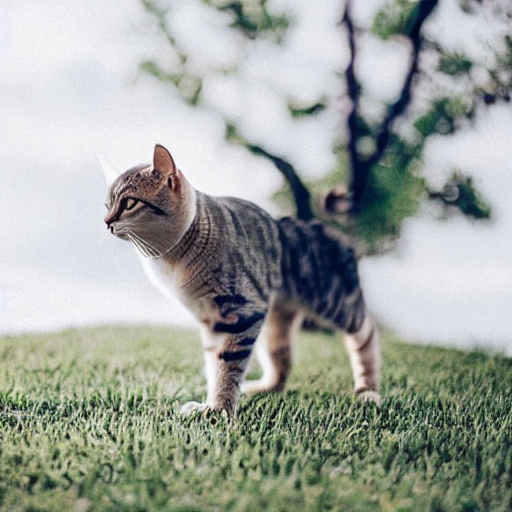

In [35]:
not_immunized_pipeline_output.images[0]

In [ ]:
###

In [31]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x * 2 + 1
z = y.mean()

print("z grad_fn:", z.grad_fn.next_functions)  # Shows the final operation
print("y grad_fn:", y.grad_fn.next_functions)  # Shows the operation creating `y`


z grad_fn: ((<AddBackward0 object at 0x16a838f70>, 0),)
y grad_fn: ((<MulBackward0 object at 0x119f1f640>, 0), (None, 0))


In [32]:
def print_graph(fn, indent=0):
    if fn is None:
        return
    print("  " * indent + str(fn))
    for next_fn, _ in fn.next_functions:
        print_graph(next_fn, indent + 1)

In [33]:
print_graph(z.grad_fn)


In [35]:
with torch.autograd.profiler.profile() as prof:
    x = torch.randn(100, 100, requires_grad=True)
    y = x ** 2
    z = y.mean()
    z.backward()

# Print a summary of the recorded operations, including tensors involved
print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::randn         5.63%      29.583us        37.73%     198.176us     198.176us             1  
                                            aten::empty         2.60%      13.668us         2.60%      13.668us      13.668us             1  
                                          aten::normal_        29.50%     154.925us        29.50%     154.925us     154.925us             1  
                                              aten::pow        14.73%      77.378us        16.38%      86.045us      43.022us             2  
      

In [37]:
from torchviz import make_dot
make_dot(z, params={"x": x, "y": y}).render("computation_graph", format="png")

'computation_graph.png'

In [12]:
decoded_latent = model.vae.decode(latent / model.vae.config.scaling_factor, return_dict=False, generator=model.generator)[0]

In [14]:
image = model.pipeline.image_processor.postprocess(decoded_latent.detach(), output_type='pil', do_denormalize=[True])

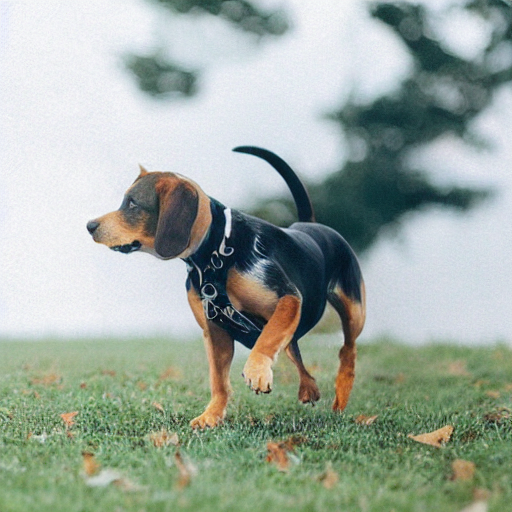

In [15]:
image[0]

In [9]:
attention_map = model.average_attention_maps(num_steps=50)

ZeroDivisionError: division by zero

In [35]:
attention_map.shape

torch.Size([64, 64, 10])

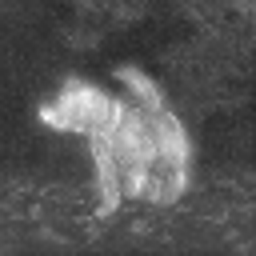

In [20]:
token = 1
token_attention_map = attention_map[:, :, token].clone()
attention_map_image = 255 * token_attention_map / token_attention_map.max()
attention_map_image = attention_map_image.unsqueeze(-1).expand(*attention_map_image.shape, 3)
attention_map_image = attention_map_image.numpy().astype(np.uint8)
# aggregated = np.array(Image.fromarray(aggregated).resize((256, 256)))
Image.fromarray(attention_map_image).resize((256, 256))

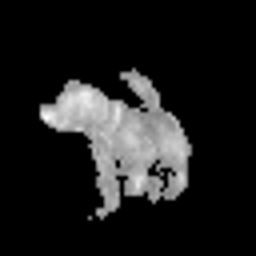

In [29]:
mask = attention_map_image * (attention_map_image > 130)
Image.fromarray(mask).resize((256, 256))

In [57]:
import gc
gc.collect()

0

In [58]:
token_attention_map.max(), token_attention_map.min() 

(tensor(0.0301), tensor(0.0047))

In [44]:
token_attention_map * (token_attention_map > token_attention_map.max() * 0.5)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [45]:
masked_token_attention_map = token_attention_map * (token_attention_map > token_attention_map.max() * 0.5)

In [47]:
masked_token_attention_map = masked_token_attention_map.unsqueeze(0).unsqueeze(0).repeat(1, 4, 1, 1) 

In [49]:
init_latent = model.vae.encode(model.preprocessed_image).latent_dist.sample(model.generator)

In [52]:
decoded_masked_latent = model.vae.decode(masked_token_attention_map * init_latent / model.vae.config.scaling_factor, return_dict=False, generator=model.generator)[0]

In [53]:
masked_image = model.pipeline.image_processor.postprocess(decoded_masked_latent.detach(), output_type='pil', do_denormalize=[True])

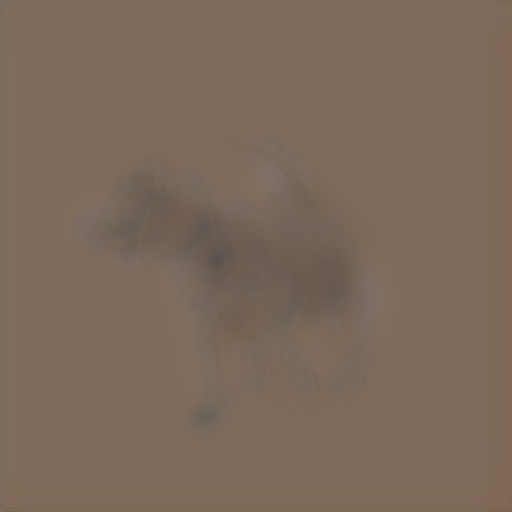

In [55]:
masked_image[0]

In [60]:
latent.shape

torch.Size([1, 4, 64, 64])

In [1]:
from memory_profiler import profile

@profile
def your_function():
    # Code you want to profile
    a = [i for i in range(100000)]  # Example line with memory impact
    b = [i * 2 for i in a]          # Another line
    del a 

In [ ]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler, StableDiffusionImg2ImgPipeline, image_processor
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import numpy as np
from PIL import Image
import torch.nn.functional as F
from diffusers.models.attention import Attention
from typing import Optional
import requests
from io import BytesIO
from tqdm.auto import tqdm
from memory_profiler import profile



class AttnProcessor:
    """
    Default processor for performing attention-related computations.
    """
    def __init__(self):
        # Initialize an empty list to store attention maps for each call
        self.attention_maps = []
        # self.hidden_states = []
        # self.encoder_hidden_states = []
        # self.attention_mask = []

    def __call__(
        self,
        attn: Attention,
        hidden_states: torch.Tensor,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        temb: Optional[torch.Tensor] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)

        res = int(np.sqrt(attention_probs.shape[1]))
        num_tokens = attention_probs.shape[-1]
        self.attention_maps.append(attention_probs.view(-1, res, res, num_tokens))
        # self.hidden_states.append(hidden_states)
        # self.encoder_hidden_states.append(encoder_hidden_states)
        # self.attention_mask.append(attention_mask)

        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

def load_image(url, size=None):
    response = requests.get(url,timeout=1)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

# def check_memory():
#     process = psutil.Process(os.getpid())
#     print(f"Memory used: {process.memory_info().rss / (1024 * 1024):.2f} MB")

def get_tensor_size(tensor: torch.Tensor) -> int:
    return tensor.element_size() * tensor.nelement() / (1024 * 1024)

class SemanticAttack():
    def __init__(self,
                 image,
                 editing_prompt,
                 token, device,
                 attention_processor_class=AttnProcessor,
                 num_inference_steps_mask=50,
                 mask_threshold=0.5,
                 perturbation_budget=0.06,
                 attacking_step_size=0.01,
                 number_of_attacking_steps=100,
                 num_diffusion_steps=10) -> None:

        self.token = token
        self.editing_prompt = editing_prompt
        self.attention_processor_class = attention_processor_class
        # self.attention_maps = {}

        # constants (move it to the sem att function
        self.mask_threshold = mask_threshold
        self.perturbation_budget = perturbation_budget
        self.attacking_step_size = attacking_step_size
        self.number_of_attacking_steps = number_of_attacking_steps
        self.num_diffusion_steps = num_diffusion_steps

        self.strength = 0.5
        self.guidance_scale = 6
        self.num_inference_steps_mask = num_inference_steps_mask

        # Initializing block for the Stable Diffusion Model
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
        self.tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder",
                                                          use_safetensors=True)
        self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet",
                                                         use_safetensors=True)
        self.scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

        # Let's also save pipeline to use it's functions
        self.pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                                                       safety_checker=None,
                                                                       requires_safety_checker=False)

        # choosing device
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
        print("Using:", self.device)

        self.generator = torch.Generator(device=self.device)
        torch.manual_seed(0)

        self.vae.to(self.device)
        self.text_encoder.to(self.device)
        self.unet.to(self.device)

        self.image = image
        self.preprocessed_image = self.pipeline.image_processor.preprocess(image).to(
            self.device)  # maybe VAE image processor?

        self.transformer_block_name_to_attention_processor_map = {}
        self.register_custom_attention_processors()

        self.mask = None
        self.latent_shape = None
        self.text_embeddings = None
        self.init_latent = None

    def upsample_attention(self, attention_map, target_res):  # works
        '''
        Upsamples attention map to a specific shape
        attention_map: torch.Tensor of size: [batch_size * n_heads, res, res, n_tokens]
        shape: tuple,
        return: torch.Tensor of size: [batch_size * n_heads, target_res, target_res, n_tokens]
        '''
        batch_size_n_heads, _, res, n_tokens = attention_map.shape
        # [batch_size * n_heads, target_res, target_res, n_tokens] -> [batch_size * n_heads * n_tokens, 1, target_res, target_res]
        attention_map = attention_map.permute(0, 3, 1, 2).reshape(-1, 1, res, res)
        attention_map = F.interpolate(attention_map, size=(target_res, target_res), mode='bicubic', align_corners=False)
        # [batch_size * n_heads * n_tokens, 1, target_res, target_res] -> [batch_size * n_heads, target_res, target_res, n_tokens]
        attention_map = attention_map.reshape(batch_size_n_heads, n_tokens, target_res, target_res).permute(0, 2, 3, 1)
        return attention_map

    def average_attention_maps(self, num_steps=1):  # works
        '''
        Upsamples the attention maps and averages them across all layers.
        num_steps: int, the number of timesteps to average over.
        '''
        resolution_to_upsample_to = 64
        to_average = []
        for key, value in self.transformer_block_name_to_attention_processor_map.items():
            attention_map = value.attention_maps[-num_steps:].copy()
            attention_map = sum(attention_map) / len(attention_map)
            res = attention_map.shape[1]
            if res == resolution_to_upsample_to:
                to_average.append(attention_map)
            else:
                to_average.append(self.upsample_attention(attention_map, resolution_to_upsample_to))
        to_average = torch.cat(to_average, dim=0)
        averaged = to_average.sum(dim=0) / to_average.shape[0]
        # del to_average
        # del attention_map
        return averaged

    # @profile
    def denoise(self):
        '''
        Generates mask using sampling from the noisy state obtained with forward pass.
        '''
        # check_memory()

        # text embeddings
        text_embeddings = self.get_text_embeddings(prompt=self.token)
        print(get_tensor_size(text_embeddings))

        with torch.no_grad():
            # timesteps
            self.scheduler.set_timesteps(self.num_inference_steps_mask, device=self.device)

            init_timestep = min(int(self.num_inference_steps_mask * self.strength), self.num_inference_steps_mask)
            t_start = max(self.num_inference_steps_mask - init_timestep, 0)

            timesteps = self.scheduler.timesteps[t_start:]
            num_inference_steps = self.num_inference_steps_mask - t_start

            # latents
            # init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            init_latent = self.get_init_latent()

            print(get_tensor_size(init_latent))
            self.latent_shape = init_latent.shape
            init_latent = self.vae.config.scaling_factor * init_latent
            noise = torch.randn(init_latent.shape, generator=self.generator, device=self.device)
            latent_timestep = timesteps[:1]
            latent = self.scheduler.add_noise(init_latent, noise, latent_timestep)

            for t in tqdm(timesteps, total=len(timesteps)):
                latent_model_input = torch.cat([latent] * 2)  # cfg
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                print(get_tensor_size(latent_model_input))

                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings,
                    # timestep_cond=None,
                    # cross_attention_kwargs=self.cross_attention_kwargs,
                    # added_cond_kwargs=added_cond_kwargs,
                    # return_dict=False,
                )[0]

                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                latent = self.scheduler.step(noise_pred, t, latent, return_dict=False)[0]
        return

    # @profile
    def generate_mask_using_forward_noise(self):
        self.denoise()
        attention_map = model.average_attention_maps(num_steps=50)
        token_attention_map = attention_map[:, :, 1]
        masked_token_attention_map = token_attention_map * (token_attention_map > token_attention_map.max() * self.mask_threshold)
        mask = masked_token_attention_map.unsqueeze(0).unsqueeze(0).repeat(1, self.latent_shape[1], 1, 1)
        self.mask = mask
        self.clean_attention_processors()

    def clean_attention_processors(self):
        for key, value in self.transformer_block_name_to_attention_processor_map.items():
            value.attention_maps = []
        # gc.collect()

    def get_text_embeddings(self, prompt):
        '''
        Gets text embedding with classifier-free guidance
        :return: text embeddings
        '''

        if self.text_embeddings is None:

            text_input = self.tokenizer(
                prompt,
                padding="max_length",
                # max_length=self.tokenizer.model_max_length,
                max_length=10,
                truncation=True,
                return_tensors="pt",
            )
            with torch.no_grad():
                # embeddings
                text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

                # classifier free guidance
                max_length = text_input.input_ids.shape[-1]
                uncond_input = self.tokenizer("", padding="max_length", max_length=max_length, return_tensors="pt")
                uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

                text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

                self.text_embeddings = text_embeddings

        else:
            text_embeddings = self.text_embeddings

        return text_embeddings

    def get_init_latent(self):
        if self.init_latent is None:
            init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            self.init_latent = init_latent
        else:
            init_latent = self.init_latent
        return init_latent

    def print_graph(self, fn, indent=0):
        if fn is None:
            return
        print("  " * indent + str(fn))
        for next_fn, _ in fn.next_functions:
            self.print_graph(next_fn, indent + 1)
    # @profile
    def timestep_universal_gradient_updating(self):
        '''
        Performs universal gradient updating.
        '''

        text_embeddings = self.get_text_embeddings(prompt=self.token)
        # text_embeddings = self.text_embeddings

        self.scheduler.set_timesteps(self.num_diffusion_steps, device=self.device)

        diffusion_timesteps = self.scheduler.timesteps

        with torch.no_grad():
            # init_latent = self.vae.encode(self.preprocessed_image).latent_dist.sample(self.generator)
            init_latent = self.get_init_latent()
            init_latent = self.vae.config.scaling_factor * init_latent
            delta = torch.zeros(init_latent.shape)


        for attacking_step in tqdm(range(self.number_of_attacking_steps), total=self.number_of_attacking_steps,
                                   desc="Attacking steps"):
            accumulated_grad = torch.zeros(init_latent.shape).requires_grad_(False)  # Accumulate gradient across timesteps
            for t in tqdm(diffusion_timesteps, total=len(diffusion_timesteps),
                          desc=f"Attacking step {attacking_step + 1}"):
                with torch.autograd.profiler.profile() as prof:
                    init_latent_adv = init_latent.clone().detach().requires_grad_(True)
                    noise = torch.randn(init_latent_adv.shape, generator=self.generator, device=self.device)
                    noised_adv_latent = self.scheduler.add_noise(init_latent_adv, noise, t)

                    latent_model_input = torch.cat([noised_adv_latent] * 2)  # cfg
                    latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                    masked_latent_model_input = self.mask * latent_model_input
                    noise_pred = self.unet(
                        masked_latent_model_input,
                        t,
                        encoder_hidden_states=text_embeddings,
                        # timestep_cond=None,
                        # cross_attention_kwargs=self.cross_attention_kwargs,
                        # added_cond_kwargs=added_cond_kwargs,
                        # return_dict=False,
                    )[0]
                    # del noise_pred

                    # calculating loss
                    attention_map = self.average_attention_maps(num_steps=1)[:, :, 1]
                    if init_latent_adv.grad is not None:
                        init_latent_adv.grad.zero_()
                    loss = torch.norm(attention_map, p=1)
                    # loss = torch.norm(latent_model_input)
                    loss.backward()

                    ##
                    # self.print_graph(attention_map)
                    ##
                    with torch.no_grad():
                        accumulated_grad += init_latent_adv.grad

                # print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))
                # for event in prof.function_events:
                #     print(event)
            # self.clean_attention_processors()
            grad = accumulated_grad / len(diffusion_timesteps)
            delta = delta + self.attacking_step_size * torch.sign(grad)
            delta.clamp_(-self.perturbation_budget, self.perturbation_budget)
            with torch.no_grad():
                init_latent_adv = (init_latent - delta).detach().requires_grad_(True)  # Reset for next step

        return init_latent_adv

    def register_custom_attention_processors(self):
        '''
        Registers a custom attention processor for each BasicTransformerBlock in the U-Net to extract attention maps after softmax.
        processor: class
        '''
        for name, module in self.unet.named_modules():
            if module.__class__.__name__ == 'BasicTransformerBlock':
                module.attn2.processor = self.attention_processor_class()
                self.transformer_block_name_to_attention_processor_map[name] = module.attn2.processor

    def show_cross_attention_maps(self, direction=["down", "up"], token=8, resolution=16):
        '''
        Shows averaged cross attention across timesteps, batch * n_heads, and layers
        with the same resolution attention maps for a given resolution and direction.
        direction: ["down", "up"]
        token: int
        resolution: int
        '''
        attention_maps = []
        for key, value in self.transformer_block_name_to_attention_processor.items():
            dir = key.split("_")[0]
            res = value.attention_maps[0].shape[1]
            if dir in direction and res == resolution:
                for item in value.attention_maps:
                    attention_maps.append(item)
        attention_maps = torch.cat(attention_maps, dim=0)
        attention_maps = attention_maps.sum(dim=0) / attention_maps.shape[0]
        attention_maps = attention_maps[:, :, token]
        attention_maps = 255 * attention_maps / attention_maps.max()
        attention_maps = attention_maps.unsqueeze(-1).expand(*attention_maps.shape, 3)
        attention_maps = attention_maps.numpy().astype(np.uint8)
        return Image.fromarray(attention_maps).resize((256, 256))


if __name__ == '__main__':
    input_image = load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
    device = "cpu"
    model = SemanticAttack(image=input_image,
                           editing_prompt="cat on the grass",
                           token='dog',
                           device="cpu",
                           attention_processor_class=AttnProcessor,
                           #  pipeline_class=StableDiffusionImg2ImgPipeline,
                           #  scheduler_class=DDIMScheduler,
                           num_inference_steps_mask=20,
                           mask_threshold=0.5,
                           perturbation_budget=0.06,
                           attacking_step_size=0.07,
                           number_of_attacking_steps=1,
                           num_diffusion_steps=2
                           )

    model.generate_mask_using_forward_noise()
    immunized_latent = model.timestep_universal_gradient_updating()
